# Traveling Salesman Problem (TSP) Implementation

This notebook serves as the main file for running the Traveling Salesman Problem (TSP) using a genetic algorithm. The objective is to find the shortest possible route that visits each city exactly once and returns to the origin city. Through iterative evolution and selection processes, we aim to optimize the solution and visualize the results effectively.


#### Import tsp algo dependencies

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np

from genetics import (
    gen_population,
    get_distance_matrix,
    validate_cities,
    crossover,
    mutation,
    tournament_selection,
    calculate_fitness,
    Params,
    generate_param_grid,
)
from tools.load import load_dataset, load_cities_name
from tools.plot import plot_route, plot_routes, plot_fitness, plot_gridsearch_result
from tuning import search_grid, Result

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Evolve Population Function

This function evolves the current population of routes in the Genetic Algorithm by applying selection, crossover, mutation, and elitism. 

### Parameters
- `population` (list): The current population of routes (chromosomes).
- `fitness_scores` (np.ndarray): An array of fitness scores corresponding to each route in the population.
- `elite_size` (int): The number of top individuals to retain for the next generation.
- `tournament_size` (int): The number of individuals competing in the tournament selection.
- `mutation_rate` (float): The probability of mutation for each offspring.

### Returns
- `list`: A new population after applying selection, crossover, mutation, and elitism.

### Steps
1. **Elitism**: Retains the top `elite_size` individuals from the current population based on fitness scores.
2. **Selection**: Selects parents using tournament selection for crossover.
3. **Crossover**: Generates offspring from selected parents using a crossover method (e.g., order crossover).
4. **Mutation**: Applies mutation to the offspring with a defined mutation rate.
5. **New Population**: Combines the elite individuals with the mutated offspring to form the new population.


In [9]:
def evolve_population(
    population: np.ndarray, fitness_scores: np.ndarray, params: Params
):
    # Step 1: Elitism - retain the top elite_size individuals
    elite_indices = fitness_scores.argsort()[-params.elite_size :][::-1]
    elite = population[elite_indices]

    # Step 2: Selection - select parents using tournament selection
    num_parents = len(population) - params.elite_size
    parents = tournament_selection(
        population, fitness_scores, params.tournament_size, num_parents
    )

    # Step 3: Crossover - generate offspring from selected parents
    offspring = np.empty((num_parents, len(parents[0])), dtype=int)
    for i in range(0, num_parents, 2):
        parent1 = parents[i]
        parent2 = parents[i + 1] if i + 1 < num_parents else parents[0]
        child1, child2 = crossover(parent1, parent2, params.crossover_type)
        offspring[i] = child1
        if i + 1 < num_parents:
            offspring[i + 1] = child2

    # Step 4: Mutation - mutate offspring
    mutated_offspring = mutation(offspring, params.mutation_rate)

    # Step 5: Create new population by combining elites and mutated offspring
    new_population = np.vstack((elite, mutated_offspring))
    return new_population

In [10]:
def run_genetic_algorithm(cities: np.ndarray, params: Params):
    # Step 1: Validate city data
    validate_cities(cities)

    # Step 2: Generate distance matrix
    distance_matrix = get_distance_matrix(cities)
    # print("Distance matrix generated.")

    # Step 3: Generate initial population
    population = gen_population("nn", params.population_size, distance_matrix)

    # Initialize variables to track progress
    best_fitness_history = []
    best_route_history = []

    for generation in range(params.generations):
        # Step 4: Calculate fitness scores
        fitness_scores = calculate_fitness(population, distance_matrix)

        # Record the best fitness and route
        best_fitness = fitness_scores.max()
        best_index = fitness_scores.argmax()
        best_fitness_history.append(best_fitness)
        best_route_history.append(population[best_index])

        # Step 5: Evolve population
        population = evolve_population(population, fitness_scores, params)

    # After all generations, find the best route
    final_fitness_scores = calculate_fitness(population, distance_matrix)
    best_index = final_fitness_scores.argmax()
    best_route = population[best_index]
    best_fitness = final_fitness_scores[best_index]

    return best_route, best_fitness, best_fitness_history, best_route_history

## Run Genetic Algorithm Function

This function executes the Genetic Algorithm to solve the Traveling Salesman Problem (TSP). It iteratively evolves a population of routes based on fitness scores until the specified number of generations is reached.

### Parameters
- `cities` (np.ndarray): An array containing the coordinates of the cities.
- `population_size` (int): The number of routes in the initial population (default is 100).
- `generations` (int): The total number of generations to evolve (default is 500).
- `elite_size` (int): The number of top routes to retain for the next generation (default is 10).
- `tournament_size` (int): The number of routes competing in tournament selection (default is 5).
- `mutation_rate` (float): The probability of mutation for each city in a route (default is 0.02).

### Returns
- `best_route` (list): The best route found after all generations.
- `best_fitness` (float): The fitness score of the best route.
- `best_fitness_history` (list): A history of the best fitness scores over the generations.
- `best_route_history` (list): A history of the best routes found over the generations.

### Steps
1. **Validate City Data**: Checks the integrity of the city data before processing.
2. **Generate Distance Matrix**: Computes the distance between each pair of cities.
3. **Generate Initial Population**: Creates an initial population of routes based on the number of cities and population size.
4. **Calculate Fitness Scores**: Evaluates the fitness of each route in the population.
5. **Record Best Route**: Keeps track of the best fitness score and corresponding route.
6. **Evolve Population**: Applies selection, crossover, and mutation to create a new population for the next generation.
7. **Final Results**: After all generations, finds the best route and visualizes the fitness over generations.


## Running the TSP Genetic Algorithm

In this section, we load the city data from a CSV file and set the parameters for the genetic algorithm. The algorithm is configured with a population size of 200 routes, 1000 generations, and various selection and mutation strategies. A random seed is set for reproducibility of results. 

The `run_genetic_algorithm` function is then called to execute the algorithm, and the best route found is visualized using the `plot_route` function. This helps illustrate the optimal path determined by the genetic algorithm.


In [11]:
eu_countries = load_cities_name("../data/city_names.csv")
dataset = load_dataset("../data/")

Loaded dataset from ../data/cities_50_dataset.csv stored at index 0.
Loaded dataset from ../data/cities_20_dataset.csv stored at index 1.
Loaded dataset from ../data/cities_500_dataset.csv stored at index 2.
Loaded dataset from ../data/cities_1000_dataset.csv stored at index 3.
Loaded dataset from ../data/cities_100_dataset.csv stored at index 4.
Loaded dataset from ../data/cities_10_dataset.csv stored at index 5.


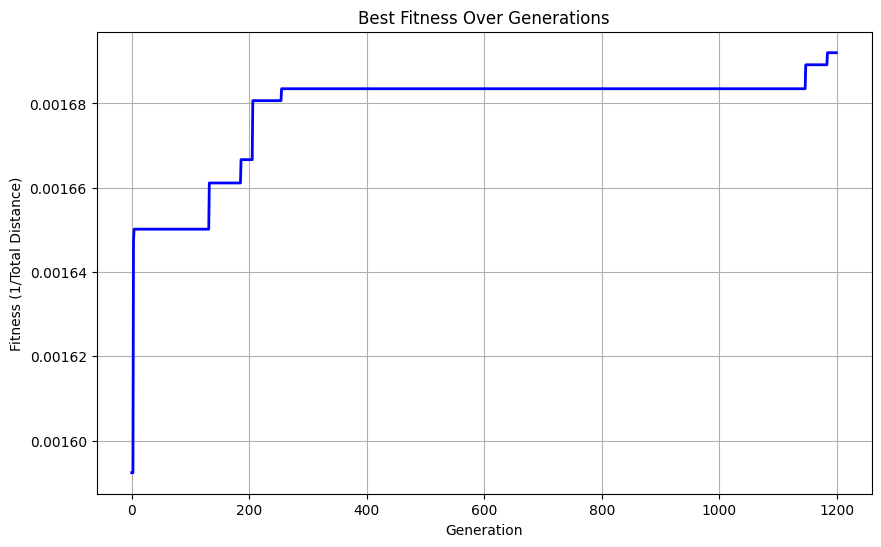

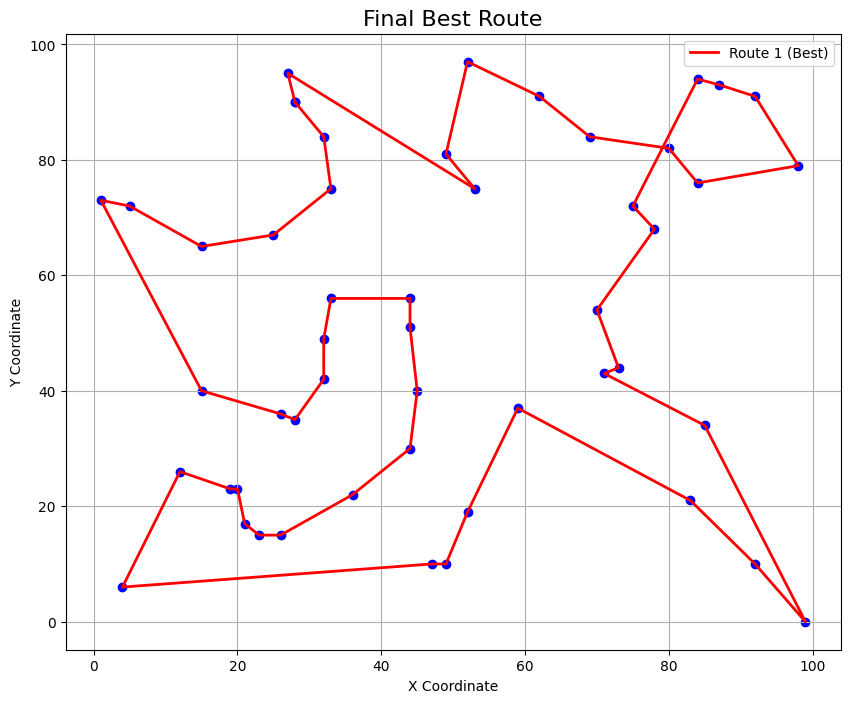

Best Fitness: 0.001692047377326565


In [22]:
# Set a random seed for reproducibility
np.random.seed(42)

data_city = dataset[0]

params_run = Params(
    population_size=700,
    generations=1200,
    elite_size=20,
    tournament_size=25,
    mutation_rate=0.03,
    mutation_type="swap",
    crossover_type="ox",
)

# Run the Genetic Algorithm
br, bf, fh, rh = run_genetic_algorithm(data_city, params_run)
plot_fitness(fh)
plot_routes([br], data_city, title="Final Best Route")
print(f"Best Fitness: {bf}")

## Parameter Tuning

This cell performs parameter tuning. Various combinations of GA parameters—such as population size, number of generations, elite size, tournament size, and mutation rate are tested to find the best configuration.

For each parameter combination, the GA is run, and the best route and corresponding fitness (solution quality) are recorded. The top 10 routes (based on fitness) are visualized, and the best overall parameter set is identified based on the highest fitness value.


In [423]:
param_grid = generate_param_grid(
    population_sizes=[200, 500, 700, 1000],
    generations_list=[200, 600, 800, 1200],
    elite_sizes=[5, 10, 20, 30],
    tournament_sizes=[3, 5, 20, 25, 40],
    mutation_rates=[0.01, 0.02],
)

results = search_grid(
    dataset[4], param_grid, run_genetic_algorithm, multithreading=False
)

43453-INFO-Starting parameter tuning for 640 combinations...
43453-INFO-Progress: 1/640 - Elapsed time: 0.80s - Estimated time remaining: 511.49s
43453-INFO-Progress: 128/640 - Elapsed time: 270.06s - Estimated time remaining: 1080.26s
43453-INFO-Progress: 192/640 - Elapsed time: 469.37s - Estimated time remaining: 1095.20s
43453-INFO-Progress: 256/640 - Elapsed time: 829.34s - Estimated time remaining: 1244.02s
43453-INFO-Progress: 320/640 - Elapsed time: 1448.71s - Estimated time remaining: 1448.71s
43453-INFO-Progress: 384/640 - Elapsed time: 1744.42s - Estimated time remaining: 1162.95s
43453-INFO-Progress: 448/640 - Elapsed time: 2415.47s - Estimated time remaining: 1035.20s
43453-INFO-Progress: 512/640 - Elapsed time: 3051.04s - Estimated time remaining: 762.76s
43453-INFO-Progress: 576/640 - Elapsed time: 3777.37s - Estimated time remaining: 419.71s
43453-INFO-Progress: 640/640 - Elapsed time: 5055.27s - Estimated time remaining: 0.00s
43453-INFO-Parameter tuning completed in 50

In [435]:
top = results[:200]
top[0].params

Params(population_size=700, generations=1200, elite_size=10, tournament_size=20, mutation_rate=0.01, mutation_type='swap', crossover_type='ox')

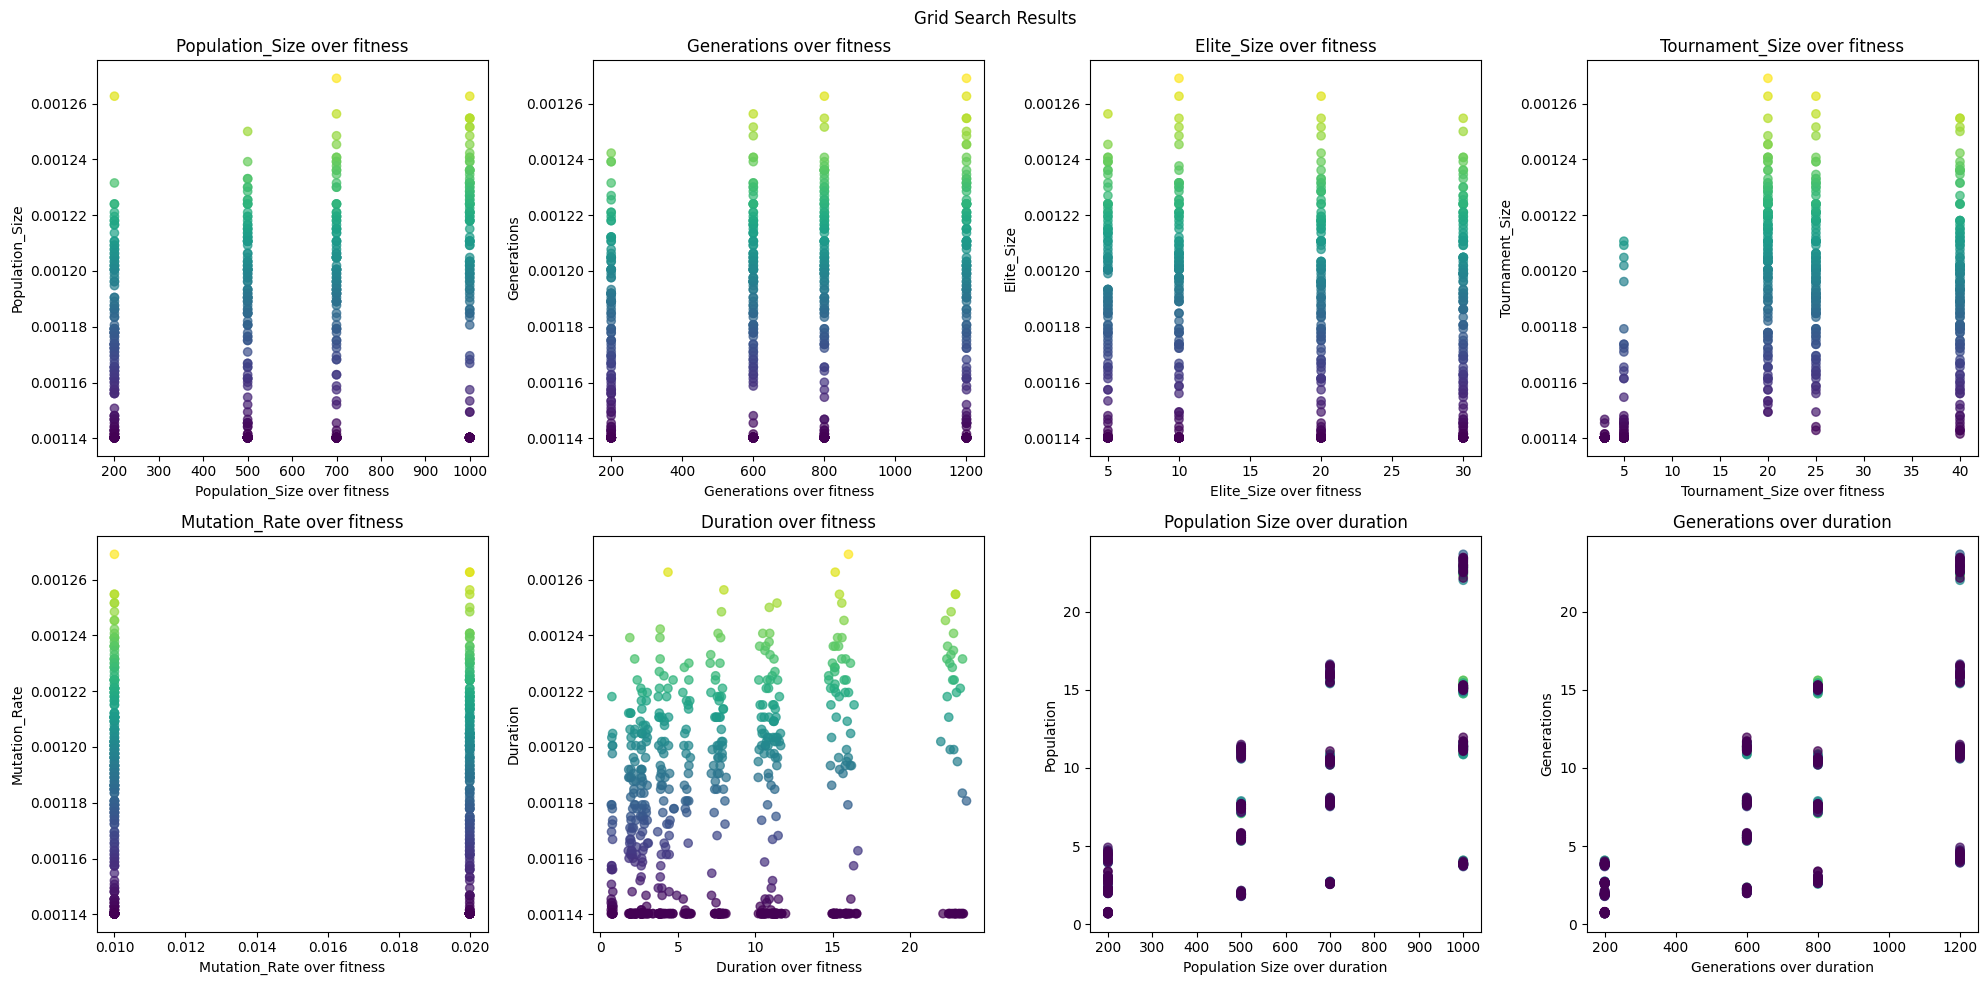

In [438]:
plot_gridsearch_result(results)

In [443]:
import pandas as pd

df = pd.DataFrame(top)
df[:10][["params", "fitness", "duration"]]

,params,fitness,duration
0,"{'population_size': 700, 'generations': 1200, ...",0.001269,16.032181
1,"{'population_size': 200, 'generations': 1200, ...",0.001263,4.363157
2,"{'population_size': 1000, 'generations': 800, ...",0.001263,15.174531
3,"{'population_size': 700, 'generations': 600, '...",0.001256,7.976244
4,"{'population_size': 1000, 'generations': 800, ...",0.001255,15.448164
5,"{'population_size': 1000, 'generations': 1200,...",0.001255,22.955054
6,"{'population_size': 1000, 'generations': 1200,...",0.001255,22.949057
7,"{'population_size': 1000, 'generations': 600, ...",0.001252,11.411085
8,"{'population_size': 1000, 'generations': 800, ...",0.001252,15.597997
9,"{'population_size': 500, 'generations': 1200, ...",0.001250,10.911145


In [447]:
df.to_csv("../data/results.csv")